In [1]:
import os
import tensorflow as tf
import numpy as np
from datetime import datetime

In [2]:
from capsnet import CapsuleNetwork, target_size, safe_norm, loss_function

In [3]:
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 16,
    "no_of_secondary_capsules": 2,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 8,
    "r":3,
}

# Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
epochs = 50
target_size = (120, 120)
batch_size = 32

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [4]:
def train(x, y):
    if len(y.shape) < 2:
        y_one_hot = tf.one_hot(y, depth=2)
    else:
        y_one_hot = y
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x, **params)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [5]:
checkpoint_path = './logs/model/capsule'

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = './logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

In [6]:
tf.summary.trace_on(graph=True, profiler=True)
model = CapsuleNetwork(**params)

X_batch = np.ones((32, *target_size, 3))
y_batch = np.ones((32, 2))
_ = train(X_batch, y_batch)

with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir)

tf.summary.trace_off()

Instructions for updating:
use `tf.profiler.experimental.start` instead.


<ipython-input-6-5bfa42d14822>:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  model = CapsuleNetwork(**params)


Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [7]:
model.summary()

Model: "capsule_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvolutionLayer (Conv2D)   multiple                  62464     
                                                                 
 PrimaryCapsule (Conv2D)     multiple                  2654336   
                                                                 
 dense (Dense)               multiple                  8704      
                                                                 
 dense_1 (Dense)             multiple                  525312    
                                                                 
 dense_2 (Dense)             multiple                  44280000  
                                                                 
Total params: 48710464 (185.82 MB)
Trainable params: 48710464 (185.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
checkpoint = tf.train.Checkpoint(model=model)

In [9]:
saved_checkpoints = set(list(map(lambda x: x.split('.')[0], os.listdir(checkpoint_path))))
saved_checkpoints

{'checkpoint',
 'fold_0-1',
 'fold_0-2',
 'fold_0-3',
 'fold_0-4',
 'fold_1-2',
 'fold_1-3',
 'fold_1-4',
 'fold_1-5',
 'fold_1-6',
 'fold_2-2',
 'fold_3-2',
 'fold_3-3',
 'fold_3-4',
 'fold_4-2',
 'fold_4-3',
 'raw-1'}

In [10]:
from dataset import get_data
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_dict = get_data("./LFWface")
test_df = pd.DataFrame(data_dict)
test_df["bin"] = test_df.labels.apply(lambda x: "focus" if x else "not-focus")

test_data_generator = ImageDataGenerator(rescale=1./255.)
test_data = test_data_generator.flow_from_dataframe(
                                     dataframe=test_df,
                                     x_col="paths",
                                     y_col="bin",
                                     target_size=target_size,
                                     seed=42,
                                     shuffle=True,
                                     label_mode="binary",
                                     batch_size=32
                                     )

100%|██████████| 13233/13233 [00:01<00:00, 9125.06it/s]


Found 13233 validated image filenames belonging to 2 classes.


In [11]:
def predict(model, x, return_prob=False, threshold=0.5):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    pred = pred[:, test_data.class_indices["focus"]]
    if return_prob:
        return pred[:, 0]
    else:
        return pred[:, 0] > threshold
        
def get_result(input_x, input_y):
    _y_pred = predict(model, input_x)
    _y = np.squeeze(input_y[:, test_data.class_indices["focus"]])
    return np.array(_y_pred), _y

In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

data_dict = {
    "Experiment": [],
    "F1": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
}

for ckpt in saved_checkpoints:
    if "fold" not in ckpt:
        continue

    restore_path = os.path.join(checkpoint_path, ckpt)
    print("restore_path", restore_path)
    checkpoint.restore(restore_path)
    with tqdm(total=len(test_data)) as pbar:
        description = "Testing ..."
        y_preds = []
        y_trues = []
        for i, (X_batch_test, y_batch_test) in enumerate(test_data):
            y_pred, y_true = get_result(X_batch_test, y_batch_test)
            
            y_preds.extend(y_pred.tolist())
            y_trues.extend(y_true.tolist())
            pbar.update(1)
            if i >= len(test_data) - 1:
                break

        data_dict["Experiment"].append(ckpt)
        data_dict["Accuracy"].append(accuracy_score(y_trues, y_preds))
        data_dict["F1"].append(f1_score(y_trues, y_preds))
        data_dict["Precision"].append(precision_score(y_trues, y_preds))
        data_dict["Recall"].append(recall_score(y_trues, y_preds))


restore_path ./logs/model/capsule/fold_1-6


100%|██████████| 414/414 [00:41<00:00,  9.96it/s]


restore_path ./logs/model/capsule/fold_1-2


100%|██████████| 414/414 [00:40<00:00, 10.17it/s]


restore_path ./logs/model/capsule/fold_3-2


100%|██████████| 414/414 [00:40<00:00, 10.15it/s]


restore_path ./logs/model/capsule/fold_3-4


100%|██████████| 414/414 [00:40<00:00, 10.31it/s]


restore_path ./logs/model/capsule/fold_0-3


100%|██████████| 414/414 [00:39<00:00, 10.40it/s]


restore_path ./logs/model/capsule/fold_1-5


100%|██████████| 414/414 [00:40<00:00, 10.27it/s]


restore_path ./logs/model/capsule/fold_3-3


100%|██████████| 414/414 [00:40<00:00, 10.23it/s]


restore_path ./logs/model/capsule/fold_0-1


100%|██████████| 414/414 [00:39<00:00, 10.37it/s]


restore_path ./logs/model/capsule/fold_0-4


100%|██████████| 414/414 [00:40<00:00, 10.34it/s]


restore_path ./logs/model/capsule/fold_1-3


100%|██████████| 414/414 [00:40<00:00, 10.22it/s]


restore_path ./logs/model/capsule/fold_2-2


100%|██████████| 414/414 [00:40<00:00, 10.17it/s]


restore_path ./logs/model/capsule/fold_4-3


100%|██████████| 414/414 [00:40<00:00, 10.22it/s]


restore_path ./logs/model/capsule/fold_1-4


100%|██████████| 414/414 [00:41<00:00, 10.02it/s]


restore_path ./logs/model/capsule/fold_0-2


100%|██████████| 414/414 [00:40<00:00, 10.26it/s]


restore_path ./logs/model/capsule/fold_4-2


100%|██████████| 414/414 [00:40<00:00, 10.11it/s]


In [88]:
import pandas as pd

pd.DataFrame(data_dict)

,Experiment,F1,Accuracy,Precision,Recall
0,fold_2-2,0.371174,0.732940,0.411278,0.338197
1,fold_0-1,0.268371,0.775032,0.598684,0.172949
2,fold_0-4,0.531261,0.792640,0.572533,0.495539
3,fold_0-3,0.490984,0.784554,0.565611,0.433754
4,fold_3-3,0.489498,0.741026,0.463600,0.518460
5,fold_1-5,0.546675,0.780549,0.531089,0.563204
6,fold_1-4,0.543870,0.770574,0.511444,0.580687
7,fold_3-4,0.505195,0.791279,0.585548,0.444234
8,fold_3-2,0.432682,0.675206,0.368315,0.524312
9,fold_4-2,0.205194,0.766417,0.542120,0.126546


In [95]:
restore_path = os.path.join(checkpoint_path, "fold_3-4")
checkpoint.restore(restore_path)
with tqdm(total=len(test_data)) as pbar:
    description = "Testing ..."
    raw_test_result = []
    TP_images = []
    TN_images = []
    FP_images = []
    FN_images = []
    for i, (X_batch_test, y_batch_test) in enumerate(test_data):
        y_pred, y_true = get_result(X_batch_test, y_batch_test)
        TP_images.append(X_batch_test[np.where(np.logical_and(y_pred == 1, y_true == 1))])
        FP_images.append(X_batch_test[np.where(np.logical_and(y_pred == 1, y_true == 0))])
        TN_images.append(X_batch_test[np.where(np.logical_and(y_pred == 0, y_true == 0))])
        FN_images.append(X_batch_test[np.where(np.logical_and(y_pred == 0, y_true == 1))])
        
        pbar.update(1)
        if i >= len(test_data) - 1:
            break

100%|██████████| 414/414 [00:43<00:00,  9.53it/s]


In [96]:
TP_images = np.vstack(TP_images)
TN_images = np.vstack(TN_images)
FP_images = np.vstack(FP_images)
FN_images = np.vstack(FN_images)

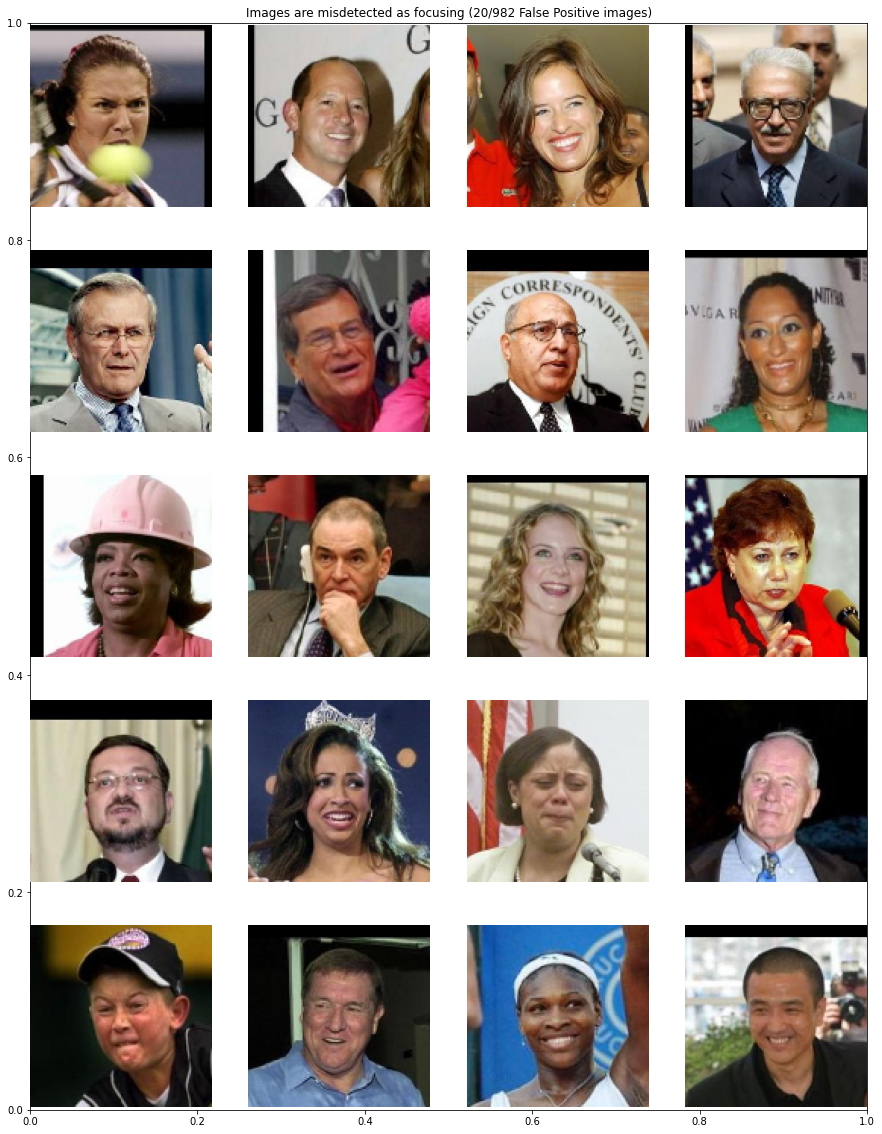

In [97]:
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(15, 20))
columns = 4
rows = 5

plt.title("Images are misdetected as focusing ({}/{} False Positive images)".format(columns * rows, FP_images.shape[0]))
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(FP_images[i])
plt.show()

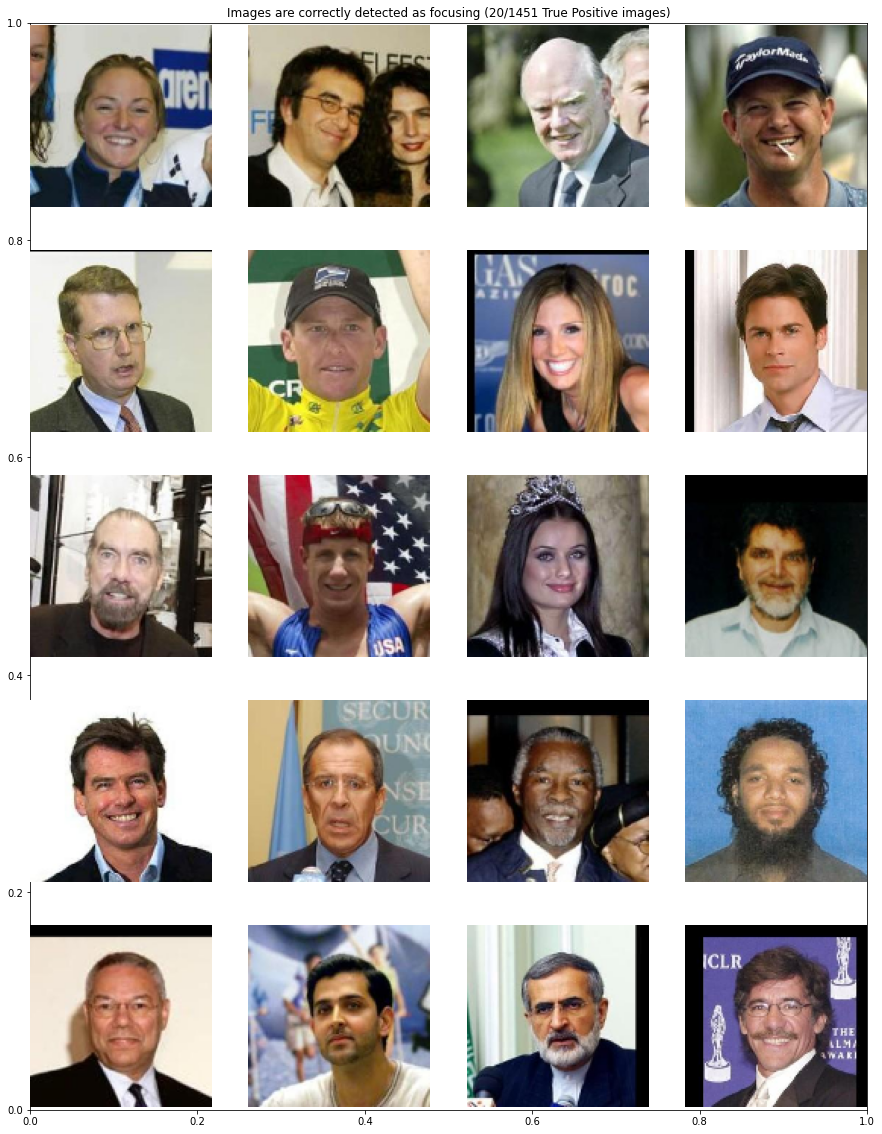

In [98]:

w = 10
h = 10
fig = plt.figure(figsize=(15, 20))
columns = 4
rows = 5

plt.title("Images are correctly detected as focusing ({}/{} True Positive images)".format(columns * rows, TP_images.shape[0]))
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(TP_images[i])
plt.show()

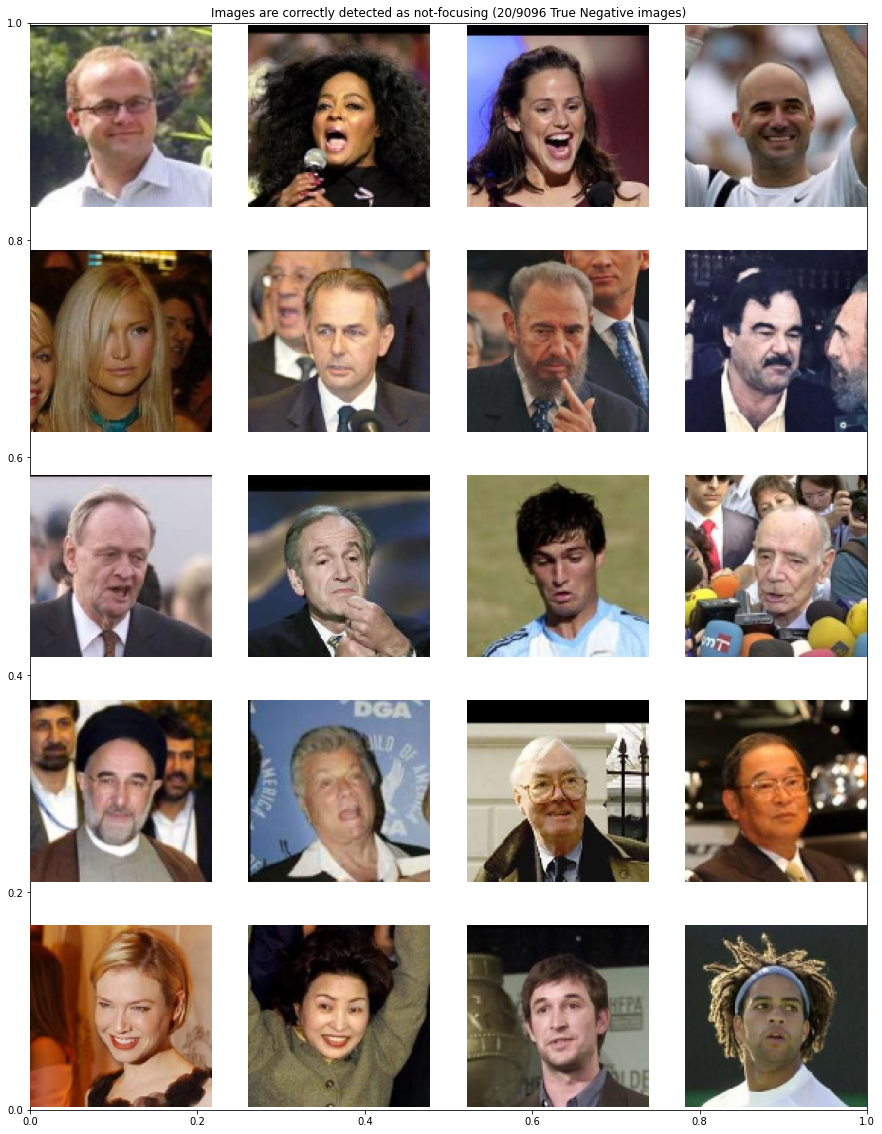

In [99]:

w = 10
h = 10
fig = plt.figure(figsize=(15, 20))
columns = 4
rows = 5

plt.title("Images are correctly detected as not-focusing ({}/{} True Negative images)".format(columns * rows, TN_images.shape[0]))
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(TN_images[i])
plt.show()